In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import the Raw CSV File

In [7]:
# read the csv file 
recipes_df = pd.read_csv('recipes_first_30.csv')

# Data Cleaning and Prep

## Types of data needed
| Data Type                    | Description                                     | Example                                         |
| ---------------------------- | ----------------------------------------------- | ----------------------------------------------- |
| Dish Metadata                | Name, category, cuisine, description            | “Spaghetti Carbonara”, “Italian”, “Main Course” |
| Ingredients                  | List of components per dish                     | “Egg, Parmesan, Pancetta, Spaghetti”            |
| Pairings                     | Known good matches                              | “Spaghetti → Garlic Bread”, “Sushi → Miso Soup” |
| User Interactions (optional) | Co-selections, purchases, clicks, ratings       | User A selected “Curry” and “Naan”              |
| Images (optional)            | Photos of dishes (useful for multimodal models) | JPEG/PNG links                                  |
| Nutritional Data             | Calories, macros                                | Optional for health-based pairing logic         |

## Data Souurce 
Food.com Recipes (Kaggle)
URL: https://www.kaggle.com/datasets/irkaal/foodcom-recipes-and-reviews

Fields: name, ingredients, steps, tags, rating

## Objective

Build a clean, enriched dataset from the raw Food.com CSV, optimized for:

- Embedding-based dish similarity
- NLP-based content filtering
- Potential future user-dish interactions

In [8]:
recipes_df.columns

Index(['RecipeId', 'Name', 'AuthorId', 'AuthorName', 'CookTime', 'PrepTime',
       'TotalTime', 'DatePublished', 'Description', 'Images', 'RecipeCategory',
       'Keywords', 'RecipeIngredientQuantities', 'RecipeIngredientParts',
       'AggregatedRating', 'ReviewCount', 'Calories', 'FatContent',
       'SaturatedFatContent', 'CholesterolContent', 'SodiumContent',
       'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent',
       'RecipeServings', 'RecipeYield', 'RecipeInstructions'],
      dtype='object')

### Step 1
SELECT KEY COLUMNS

We selected specific columns from the raw dataset that are relevant to the use case:

- RecipeId, Name, Description: Basic identifiers and textual content.
- RecipeIngredientParts, RecipeIngredientQuantities: Core content of each recipe.
- RecipeCategory, Keywords: Help classify dishes by type or tags.
- AggregatedRating, ReviewCount: Useful for quality filtering.
- Nutrition columns: Used to form a nutrient vector.
- We ignore irrelevant columns (e.g., AuthorId, DatePublished, Images) to reduce noise.

In [9]:
# Select and rename 
df_clean = recipes_df[['RecipeId', 'Name', 'Description', 'RecipeIngredientParts',
               'RecipeIngredientQuantities', 'RecipeCategory', 'Keywords',
               'RecipeInstructions', 'AggregatedRating', 'ReviewCount',
               'Calories', 'FatContent', 'ProteinContent', 'CarbohydrateContent']].copy()

In [33]:
# Genera;l check to see we have the correct column count
len(df_clean.columns)

14

## Step 2

Transform the Data
- Renamed Columns to normalized, lower-case, consistent field names (dish_id, name, etc.).
- Parsed JSON-like strings in columns (RecipeIngredientParts, Keywords) into real Python lists using ast.literal_eval.

Renaming provides semantic clarity and consistency throughout the pipeline. The dataset includes list-like fields stored as strings (e.g., "['chicken', 'garlic']"), which must be parsed into Python lists so that they’re usable in ML and NLP workflows. These parsed lists are crucial for generating embeddings, filtering, and extracting ingredient features

In [10]:
# Rename the data
df_clean.rename(columns={
    'RecipeId': 'dish_id',
    'Name': 'name',
    'Description': 'description',
    'RecipeIngredientParts': 'ingredients',
    'RecipeIngredientQuantities': 'ingredient_qty',
    'RecipeCategory': 'category',
    'Keywords': 'tags',
    'RecipeInstructions': 'instructions',
    'AggregatedRating': 'rating',
    'ReviewCount': 'review_count'
}, inplace=True)

In [11]:
# # Parse stringified lists
import ast
import re

# # def safe_literal_eval(val):
# #     try:
# #         return ast.literal_eval(val)
# #     except Exception as e:
# #         print(f"Failed to parse: {val}\nError: {e}")
# #         return None

def convert_r_list_to_python(val):
    # Handle NaN, None
    if val is None or isinstance(val, float) and np.isnan(val):
        return []

    # Handle already-structured input
    if isinstance(val, (list, np.ndarray)):
        return list(val)

    # Handle string input
    if isinstance(val, str):
        val = val.strip()
        if val == "" or val.lower() in ("none", "nan"):
            return []

        # Convert R-style syntax
        if val.startswith("c(") and val.endswith(")"):
            val = re.sub(r'^c\((.*)\)$', r'[\1]', val)

        # Replace unquoted NA with None
        val = re.sub(r'\bNA\b', 'None', val)

        try:
            result = ast.literal_eval(val)
            return list(result) if isinstance(result, (tuple, set)) else result
        except Exception as e:
            print(f"Failed to parse: {val}\nError: {e}")
            return []

    return []

# Apply to each column safely
df_clean['ingredients'] = df_clean['ingredients'].apply(convert_r_list_to_python)
df_clean['ingredient_qty'] = df_clean['ingredient_qty'].apply(convert_r_list_to_python)
df_clean['tags'] = df_clean['tags'].apply(lambda x: convert_r_list_to_python(x) if x is not None and not (isinstance(x, float) and np.isnan(x)) else [])


# Combine nutrients into a dictionary
df_clean['nutrients'] = df_clean.apply(lambda row: {
    'calories': row.get('Calories'),
    'protein': row.get('ProteinContent'),
    'fat': row.get('FatContent'),
    'carbs': row.get('CarbohydrateContent')
}, axis=1)

# Drop individual nutrient cols
df_clean.drop(columns=['Calories', 'ProteinContent', 'FatContent', 'CarbohydrateContent'], inplace=True)

## STEP 3 

Filter and Clean

- Drop recipes with fewer than 3 ingredients as they often lack substance or are incomplete
- Remove low-reviewed dishes (e.g., review_count < 5).Low review count usually means the data is less reliable or popular.
- Keep only recipes with non-null ratings. Filtering helps improve signal-to-noise ratio, ensuring that downstream training (especially if supervised) works with meaningful examples.

In [12]:
df_clean = df_clean[df_clean['ingredients'].apply(len) > 2]
df_clean = df_clean[df_clean['review_count'] >= 5]
df_clean = df_clean[df_clean['rating'].notnull()]

## STEP 4

Feature Enrichment

Combine name + description + ingredients into a single string for embeddings
- Embedding models (especially sentence transformers or LLMs) perform best when given rich, contextually complete text
- By concatenating the dish name, description, and ingredient list, we form a comprehensive textual representation for each dish
- This can then be used to:
   - Generate embeddings
   - Perform semantic search
   - Measure cosine similarity between dishes

In [13]:
df_clean['embedding_text'] = df_clean.apply(lambda row: 
    f"{row['name']}. {row['description'] or ''}. Ingredients: {', '.join(row['ingredients'])}.", axis=1)


##  STEP 5

Export the date to S3 for Model Training. Amazon SageMaker and other AWS ML services ingest data from S3.
We save the data in a JSON Lines (JSONL) format. Using JSON Lines format makes it easy as shown in the below table

| Feature                | Benefit                                                         |
| ---------------------- | --------------------------------------------------------------- |
| **Streaming-friendly** | Easily read one line at a time, ideal for huge files            |
| **Parallelizable**     | Lines can be processed independently in distributed systems     |
| **Fault-tolerant**     | Corruption in one line doesn't break the rest of the file       |
| **Compatible**         | Works well with tools like `jq`, `pandas`, `Spark`, `SageMaker` |
| **Efficient**          | Append new records without rewriting the entire file            |


In [14]:
df_clean.to_json('cleaned_dishes.json', orient='records', lines=True)

## Step 6

Explore the dataset. 

<Axes: >

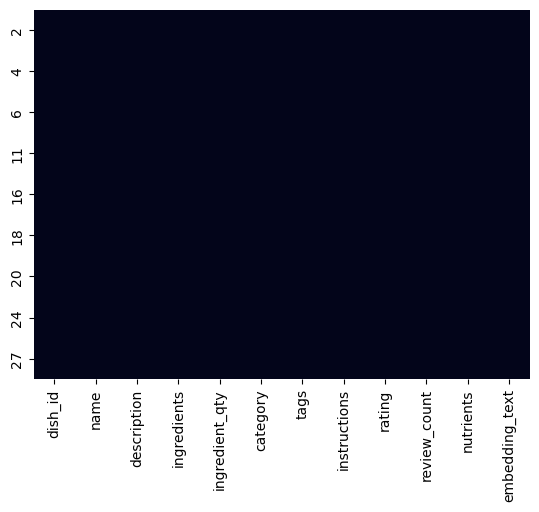

In [18]:
# If there are any null values the will show up as a brighter color. In this case we have no null
sns.heatmap(df_clean.isnull(), cbar = False)


In [16]:
# We can confirm non nulls further using the below check 
df_clean.isnull().sum()

dish_id           0
name              0
description       0
ingredients       0
ingredient_qty    0
category          0
tags              0
instructions      0
rating            0
review_count      0
nutrients         0
embedding_text    0
dtype: int64

In [19]:
# Statistical summary of the dataframe
df_clean.describe()

,dish_id,rating,review_count
count,9.000000,9.000000,9.000000
mean,52.333333,4.833333,33.555556
std,9.137833,0.250000,51.872707
min,40.000000,4.500000,7.000000
25%,44.000000,4.500000,11.000000
50%,54.000000,5.000000,19.000000
75%,58.000000,5.000000,23.000000
max,66.000000,5.000000,171.000000


We would like to check for duplicates and remove them. To do this we call df_clean.duplicated().
The function duplicated requires all columns to contain hashable types (e.g., strings, numbers, tuples). 
Lists and dictionaries are unhashable, so duplicated() fails if your DataFrame has columns with lists. To fix this

- Find all columns with lists or dictionaries
- Make a deep copy of your dataframe
- Convert the list or dictionary column to tuples and update you copy df
- run the duplicated().sum() on the copy df

In [27]:
# Find all the columns with lists or dictionaries
list_columns = []
dict_columns = []

for col in df_clean.columns:
    sample = df_clean[col].dropna().head(10)  # check first 10 non-null rows
    if sample.apply(lambda x: isinstance(x, list)).any():
        list_columns.append(col)
    if sample.apply(lambda x: isinstance(x, dict)).any():
        dict_columns.append(col)

# Combine and deduplicate
complex_columns = list(set(list_columns + dict_columns))

print("Columns with lists:", list_columns)
print("Columns with dictionaries:", dict_columns)
print("All complex columns (lists or dicts):", complex_columns)

Columns with lists: ['ingredients', 'ingredient_qty', 'tags']
Columns with dictionaries: ['nutrients']
All complex columns (lists or dicts): ['ingredients', 'ingredient_qty', 'nutrients', 'tags']


### Once you have the columns with Lists or dictionaries convert these to tuples temporarily

In [36]:
# Make a deep copy of your dataframe

df_temp = df_clean.copy() 

# Convert the list or dictionary column to tuples and update you copy df
for col in complex_columns:
    df_temp[col] = df_temp[col].apply(lambda x: tuple(x) if isinstance(x, (list, dict)) else x)

# run the duplicated().sum() on the copy df
duplicate_count = df_temp.duplicated().sum()

print(f"Duplicate rows: {duplicate_count}")

Duplicate rows: 0
